# Extrinsics Calibration

In [92]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import numpy as np

from typing import List

import matplotlib.pyplot as plt

from dt_computer_vision.camera import CameraModel, Pixel

from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoard8by6
from dt_computer_vision.camera.calibration.extrinsics.chessboard import find_corners
from dt_computer_vision.camera.calibration.extrinsics.rendering import draw_corners

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
this_dir: str = os.path.abspath('')
assets_dir: str = os.path.join(this_dir, "..", "assets")
image_fpath: str = os.path.join(assets_dir, f"image1.jpg")
image: np.ndarray = cv2.imread(image_fpath)
board = CalibrationBoard8by6

camera_properties = {
    "width": 640,
    "height": 480,
    "K": [[295.79606866959824, 0.0, 321.2621599038631],
          [0.0, 299.5389048862878, 241.73616515312332],
          [0.0, 0.0, 1.0]],
    "D": [-0.23543978771661125,
          0.03637781479419574,
          -0.0033069818601306755,
          -0.0012140708179525926,
          0.0],
    "P": [[201.14027404785156, 0.0, 319.5586620845679, 0.0],
          [0.0, 239.74398803710938, 237.60151004037834, 0.0],
          [0.0, 0.0, 1.0, 0.0]]
}
camera = CameraModel(**camera_properties)

assert image.shape == (480, 640, 3)

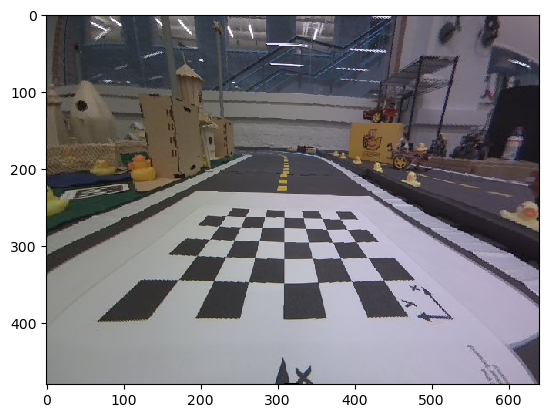

In [94]:
# rectify image
image_rect = camera.rectifier.rectify(image)
rectified = cv2.cvtColor(image_rect, cv2.COLOR_BGR2RGB)
plt.imshow(rectified)

In [95]:
# find corners
corners: List[Pixel] = find_corners(image_rect, board)
print(f"Found {len(corners)} corners.")
assert len(corners) == (board.columns) * (board.rows)

Found 35 corners.


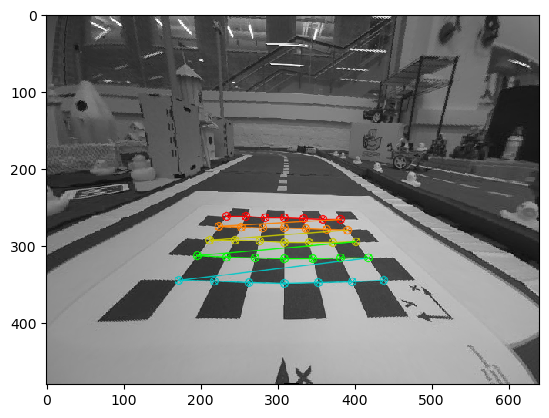

In [96]:
# draw detected corners on top of the image
image_w_corners = draw_corners(image_rect, board, corners)
image_w_corners_rgb = cv2.cvtColor(image_w_corners, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_corners_rgb)

In [97]:
# estimate homography
from dt_computer_vision.camera.calibration.extrinsics.ransac import estimate_homography

H = estimate_homography(corners, board, camera)

print(H)

[[ 0.45484525  0.33783685  0.11218921]
 [-0.02801287  1.02463437 -0.07835274]
 [-0.19216963  3.63163831  1.        ]]


In [98]:
# project the principal point onto the plane
ground_pp = np.dot(H, [0, 0, 1])
ground_pp = (ground_pp / ground_pp[2])[:2]
# manually measured when the image above was taken
# TODO: fix this
expected_pp = [0.4, 0]

# compute error estimate
pp_error = np.linalg.norm(ground_pp - expected_pp)
print(f"Error is ~{pp_error * 100:.2f}cm.")

# make sure the error is within 3cm
# assert pp_error <= 0.03

Error is ~29.83cm.


# Ground Reprojection

In [99]:
from typing import List
from dt_computer_vision.camera.calibration.extrinsics.chessboard import get_ground_corners_and_error, compute_placement_error

from dt_computer_vision.camera import NormalizedImagePoint
from dt_computer_vision.ground_projection import GroundPoint

image_corners: List[NormalizedImagePoint]
ground_corners: List[GroundPoint]
ground_corners_projected: List[GroundPoint]
errors: List[float]

image_corners, ground_corners, ground_corners_projected, errors = get_ground_corners_and_error(camera, corners, board, H)

for i, (image_corner, ground_corner, ground_corner_projected, error) in enumerate(zip(image_corners, ground_corners, ground_corners_projected, errors)):
    # print out (image point, ground computed, and ground oracle) points
    print(f"{i}\t: I[{image_corner}] -> Gc[{ground_corner_projected}] ~ G[{ground_corner}]: {float(error):.4f}m")

# compute average error
avg_error = np.average(errors)
std_error = np.std(errors)
print(f"Overall error: {avg_error:.4f}m +/- {std_error:.4f}m")

# find all corners that are on the X and Y axis of the calibration pattern (the lines partitioning the board into 4 equal quadrants)
placement_error: float = compute_placement_error(corners, board, errors)
print(f"Placement error: {placement_error:.4f}m")

0	: I[P(-0.2947, 0.0665)] -> Gc[P(0.0005, -0.0015)] ~ G[P(0.16, -0.124)]: 0.2011m
1	: I[P(-0.2099, 0.0693)] -> Gc[P(0.0311, -0.0012)] ~ G[P(0.191, -0.124)]: 0.2017m
2	: I[P(-0.1264, 0.0727)] -> Gc[P(0.0615, -0.0002)] ~ G[P(0.222, -0.124)]: 0.2027m
3	: I[P(-0.0415, 0.0746)] -> Gc[P(0.0927, -0.0006)] ~ G[P(0.253, -0.124)]: 0.2023m
4	: I[P(0.0443, 0.0761)] -> Gc[P(0.1247, -0.0012)] ~ G[P(0.284, -0.124)]: 0.2011m
5	: I[P(0.1263, 0.0798)] -> Gc[P(0.1553, -0.0001)] ~ G[P(0.315, -0.124)]: 0.2021m
6	: I[P(0.2053, 0.0813)] -> Gc[P(0.1856, -0.0007)] ~ G[P(0.346, -0.124)]: 0.2024m
7	: I[P(-0.3274, 0.1103)] -> Gc[P(0.0004, 0.03)] ~ G[P(0.16, -0.093)]: 0.2015m
8	: I[P(-0.2305, 0.1154)] -> Gc[P(0.0316, 0.0317)] ~ G[P(0.191, -0.093)]: 0.2023m
9	: I[P(-0.1352, 0.1179)] -> Gc[P(0.0622, 0.0318)] ~ G[P(0.222, -0.093)]: 0.2027m
10	: I[P(-0.0417, 0.1192)] -> Gc[P(0.0926, 0.0312)] ~ G[P(0.253, -0.093)]: 0.2028m
11	: I[P(0.0517, 0.1223)] -> Gc[P(0.1234, 0.0317)] ~ G[P(0.284, -0.093)]: 0.2033m
12	: I[P(0.1458

# GUI

In [100]:
from matplotlib.pyplot import figure

from dt_computer_vision.camera.calibration.extrinsics.rendering import draw_gui, top_view_projected_corners
from dt_computer_vision.ground_projection.rendering import draw_grid_image

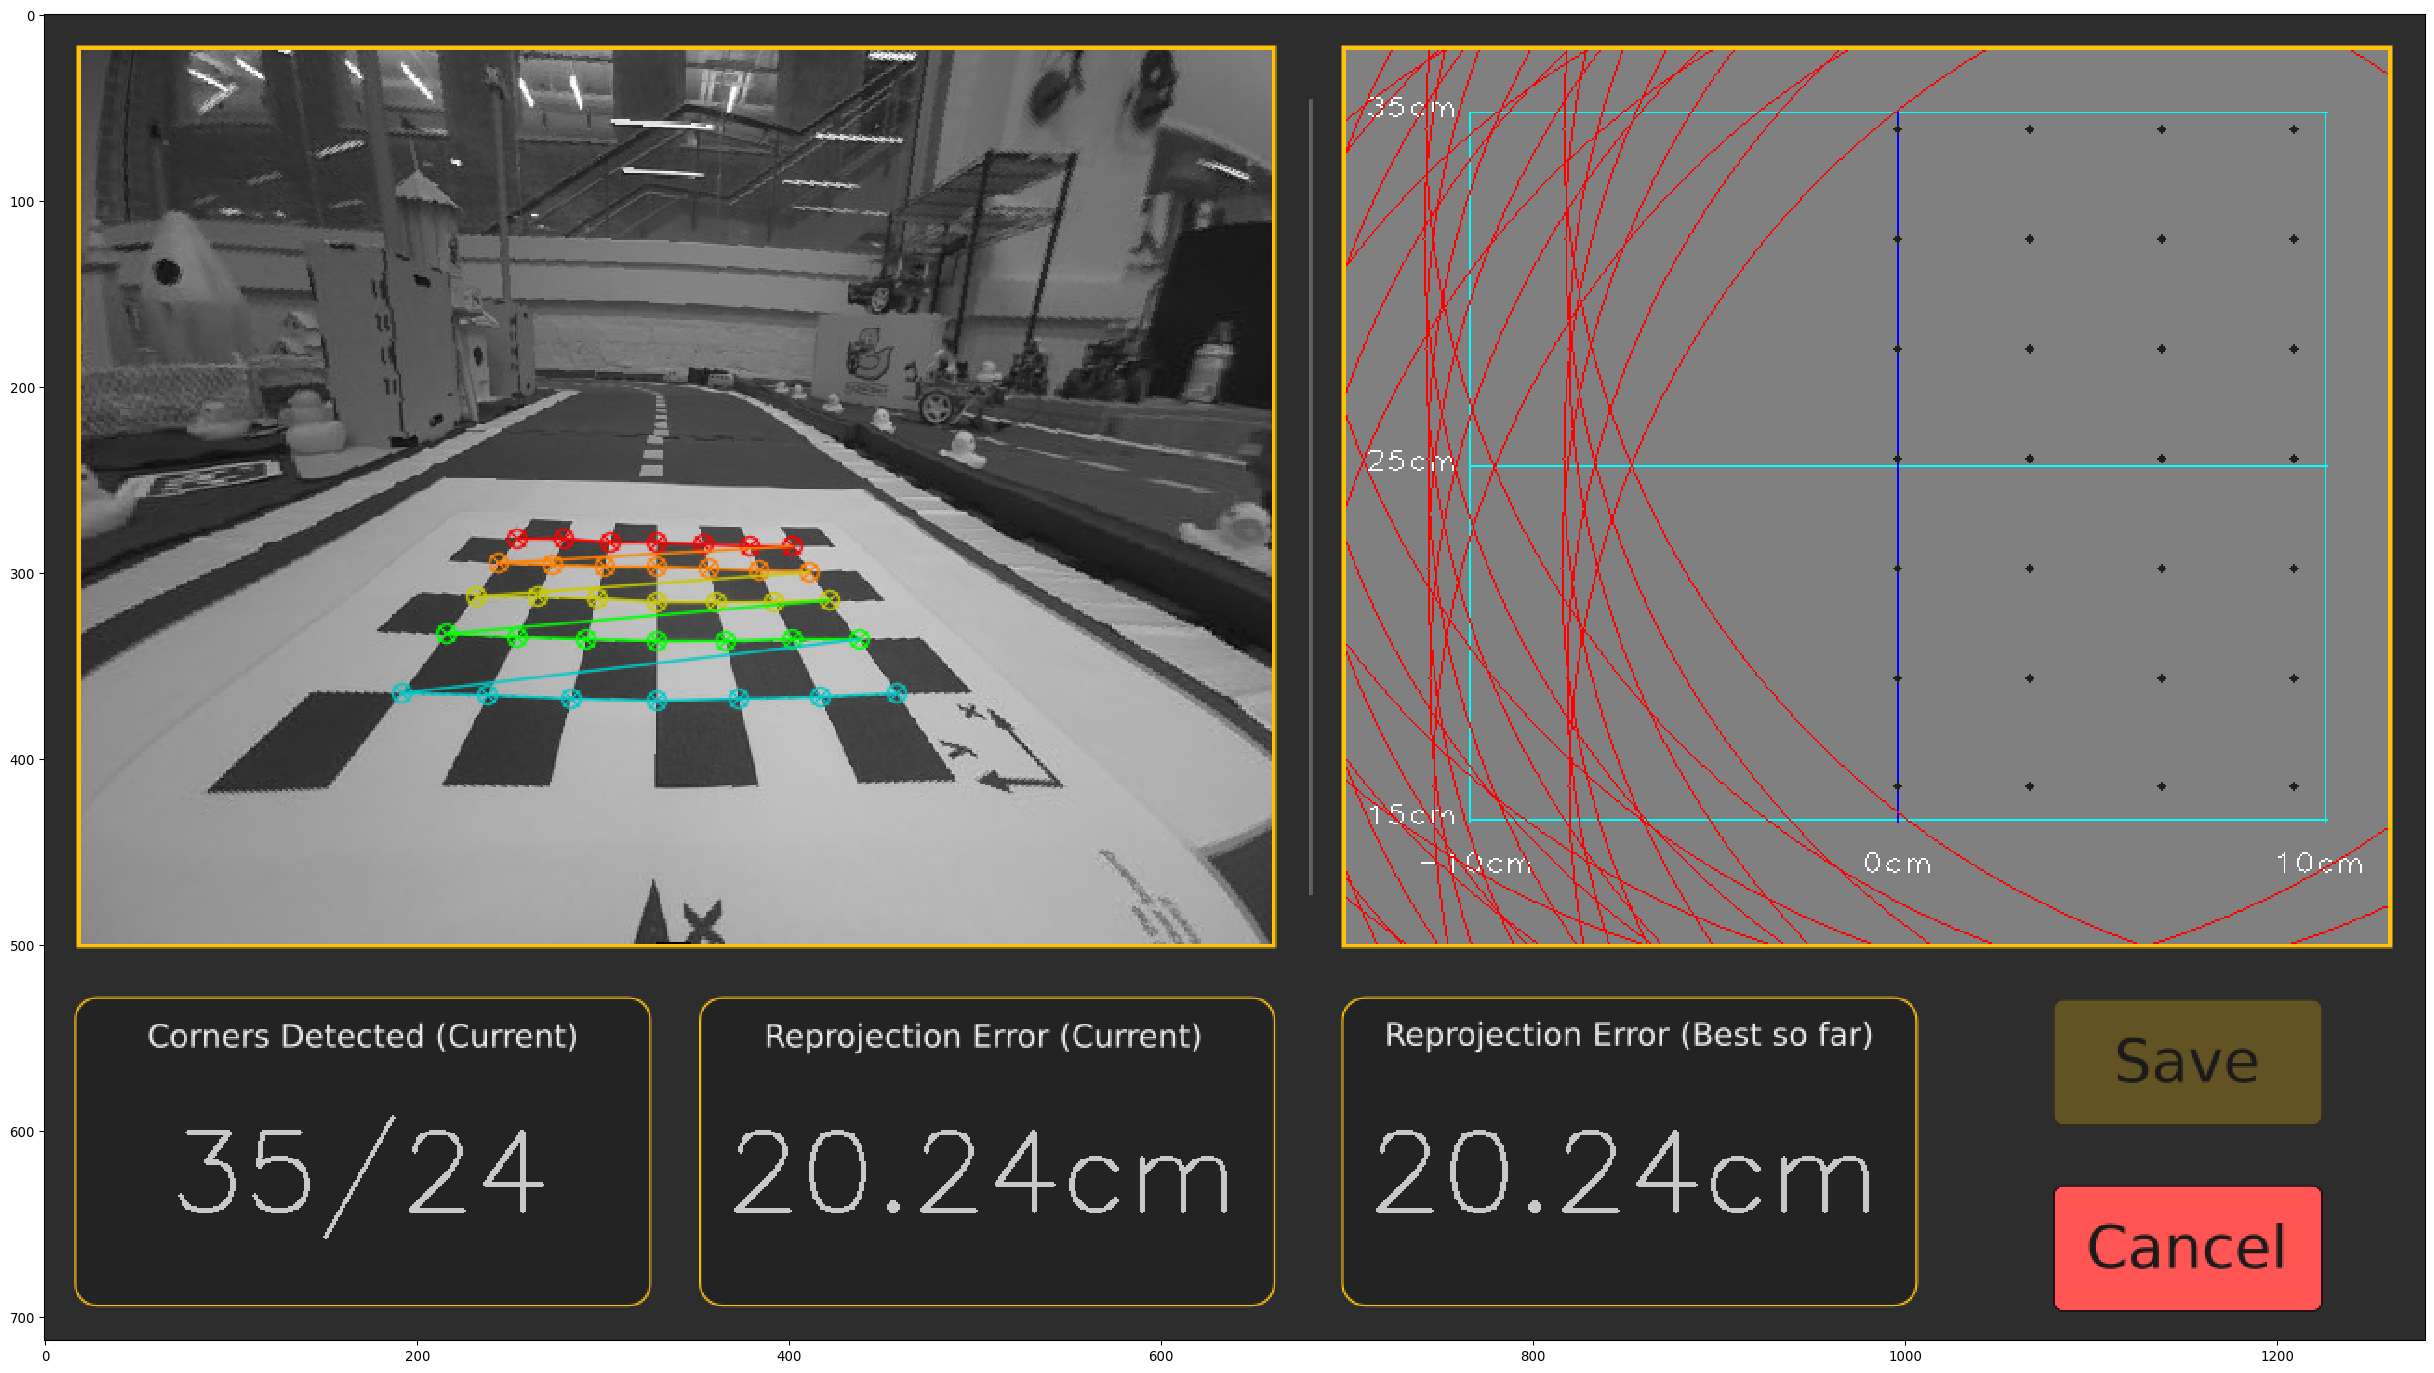

In [101]:
fig = figure(figsize=(32, 18), dpi=96)

right = top_view_projected_corners(
    ground_corners,
    errors,
    (560, 480),
    start_y=0.15,
)

gui = draw_gui(False, image_w_corners, right, len(corners), board, avg_error, avg_error)

gui = cv2.cvtColor(gui, cv2.COLOR_BGR2RGB)
plt.imshow(gui)